### University of Virginia

### NYC Housing Complaints Dataset Summary


 Instructions
5.11: Final Project Assignment

At this point in the course, you should be training and evaluating models. Please create a Jupyter Notebook containing a concise summary of your dataset (described in submission instructions).

    At a minimum, the file should include a summary containing:
        Number of records
        Number of columns
        Statistical summary of response variable
        Statistical summary of potential predictor variables (if there are a large number of predictors, select the top 10)
        Note: Summarize categorical variables with counts and percentages for each level and summarize numerical variables with mean/quantiles/standard deviation.
        Include up to five helpful graphs


In [1]:
# Change width of Jupyter notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.feature import HashingTF
from pyspark.mllib.classification import LogisticRegressionWithSGD
from pyspark.sql import SparkSession
from pyspark.sql.functions import pandas_udf, PandasUDFType, col, split, explode
from pyspark.sql.types import *
import pandas as pd
spark = SparkSession.builder \
    .master('local') \
    .appName('nyc_merged_complaints_data') \
    .config('spark.executor.memory', '28g') \
    .config('spark.driver.memory','4g')\
    .config("spark.cores.max", "6") \
    .getOrCreate()

Data was obtained from https://data.cityofnewyork.us/Housing-Development/Housing-Maintenance-Code-Complaints/uwyv-629c and https://data.cityofnewyork.us/Housing-Development/Complaint-Problems/a2nx-4u46. The two datasets were merged by using the “Complaint ID” column in both datasets as the joint to form one merged dataset. After cleaning the dataset we have approximately 4.1 million rows and 30 columns of data to work with.

In [2]:
# Read in data
merged_df=spark.read.csv("NYC_Merged_Complaints_Data.csv",inferSchema=True, header=True)
merged_df.show(5)

+---+-----------+---------+----------+------------+------------+----------------+------+---------+---------------+-------------+---------------+-------------+------+--------------------+--------+------+----------+--------------------+----------+---------+-------+-----------+----------+-----+-----+---+---------+--------------+------------+
|_c0|ComplaintID|ProblemID|UnitTypeID|    UnitType|SpaceTypeID |       SpaceType|TypeID|     Type|MajorCategoryID|MajorCategory|MinorCategoryID|MinorCategory|CodeID|                Code|StatusID|Status|StatusDate|   StatusDescription|BuildingID|BoroughID|Borough|HouseNumber|StreetName|  Zip|Block|Lot|Apartment|CommunityBoard|ReceivedDate|
+---+-----------+---------+----------+------------+------------+----------------+------+---------+---------------+-------------+---------------+-------------+------+--------------------+--------+------+----------+--------------------+----------+---------+-------+-----------+----------+-----+-----+---+---------+------

In [4]:
# Number of records and Number of columns
type(merged_df),merged_df.count(),len(merged_df.columns)

(pyspark.sql.dataframe.DataFrame, 4058289, 30)

Looking at the columns/variables that we have available to us, several are descriptive IDs which we will drop in our analysis (ComplaintID,problemID, UnitTypeID, SpaceTypeID, typeID, etc.) but we keep for now for our proprocessing steps. 

The variables that we will focus on in our regression analysis include: SpaceType, Type, MajorCategory, MinorCategory, Code, and Zip. 

We may look to include census data (such as avg income by zip code) in a later step.

In [22]:
reduced_df = merged_df[['ComplaintID', 'ProblemID', 'SpaceType', 'TypeID', 'Type', 'MajorCategoryID', 'MajorCategory', 'MinorCategoryID', 'MinorCategory', 'CodeID', 'Code', 'Zip']]

reduced_df.show(5)

+-----------+---------+----------------+------+---------+---------------+-------------+---------------+-------------+------+--------------------+-----+
|ComplaintID|ProblemID|       SpaceType|TypeID|     Type|MajorCategoryID|MajorCategory|MinorCategoryID|MinorCategory|CodeID|                Code|  Zip|
+-----------+---------+----------------+------+---------+---------------+-------------+---------------+-------------+------+--------------------+-----+
|    2397487|  3768602|ENTIRE APARTMENT|     2|HAZARDOUS|             13|     NONCONST|            106|       VERMIN|   886|             ROACHES|11432|
|    2397487|  3768603|           OTHER|     2|HAZARDOUS|             13|     NONCONST|            106|       VERMIN|   884|                MICE|11432|
|    2397487|  3768604| ENTIRE BUILDING|     2|HAZARDOUS|             28|PAINT/PLASTER|            198|         WALL|  1400|PAINT DIRTY AND U...|11432|
|    2397487|  3768605|           OTHER|     1|EMERGENCY|             13|     NONCONST| 

In [23]:
#merged_df.printSchema()
reduced_df.printSchema()

root
 |-- ComplaintID: integer (nullable = true)
 |-- ProblemID: integer (nullable = true)
 |-- SpaceType: string (nullable = true)
 |-- TypeID: integer (nullable = true)
 |-- Type: string (nullable = true)
 |-- MajorCategoryID: integer (nullable = true)
 |-- MajorCategory: string (nullable = true)
 |-- MinorCategoryID: integer (nullable = true)
 |-- MinorCategory: string (nullable = true)
 |-- CodeID: integer (nullable = true)
 |-- Code: string (nullable = true)
 |-- Zip: string (nullable = true)



The main function of the following code block is to convert the data in the ReceivedDate and StatusDate columns into DateType so that we can calculate how long it took for each complaint to be filed as complete. The resulting "closeTime" column displays the number of days it took for the complaint to be closed. 

In [6]:
from pyspark.sql.functions import unix_timestamp

# preprocessing: convert dates to datetime format and calculate response variable - closing time
timeDiff = (unix_timestamp('StatusDate', 'MM/dd/yyyy') - unix_timestamp('ReceivedDate', 'MM/dd/yyyy')) / 86400 #seconds per day
timeDiff = timeDiff.cast(IntegerType())

# add closing time (time for complaint to be resolved) to dataframe
merged_df = merged_df.withColumn("closeTime", timeDiff)
merged_df.show(5)
#Reference: https://stackoverflow.com/questions/47701339/subtracting-two-date-columns-in-pyspark-python

+---+-----------+---------+----------+------------+------------+----------------+------+---------+---------------+-------------+---------------+-------------+------+--------------------+--------+------+----------+--------------------+----------+---------+-------+-----------+----------+-----+-----+---+---------+--------------+------------+---------+
|_c0|ComplaintID|ProblemID|UnitTypeID|    UnitType|SpaceTypeID |       SpaceType|TypeID|     Type|MajorCategoryID|MajorCategory|MinorCategoryID|MinorCategory|CodeID|                Code|StatusID|Status|StatusDate|   StatusDescription|BuildingID|BoroughID|Borough|HouseNumber|StreetName|  Zip|Block|Lot|Apartment|CommunityBoard|ReceivedDate|closeTime|
+---+-----------+---------+----------+------------+------------+----------------+------+---------+---------------+-------------+---------------+-------------+------+--------------------+--------+------+----------+--------------------+----------+---------+-------+-----------+----------+-----+-----+

Our response variable, closeTime, describes the amount of time for a complaint to be closed/resolved. The possible values range from -180 (clearly a data error) to 6531 days, with an average complaint closing time of 13.6 days and a standard deviation of 37.6 days. 

In [7]:
# Statistical summary of response variable
response_variable = merged_df.select(["closeTime"])
response_variable.describe().toPandas().transpose

<bound method DataFrame.transpose of   summary           closeTime
0   count             4057769
1    mean  13.612062194767617
2  stddev  37.547546880054725
3     min                -179
4     max                6531>

In [8]:
quantiles = merged_df.approxQuantile("closeTime", [0.25,0.50,0.75], 0.1)

In [9]:
quantiles

[4.0, 10.0, 18.0]

In our exploration of the response variable, we also calculate simple correlations between our response variable and some of the potential numerical predictors. 

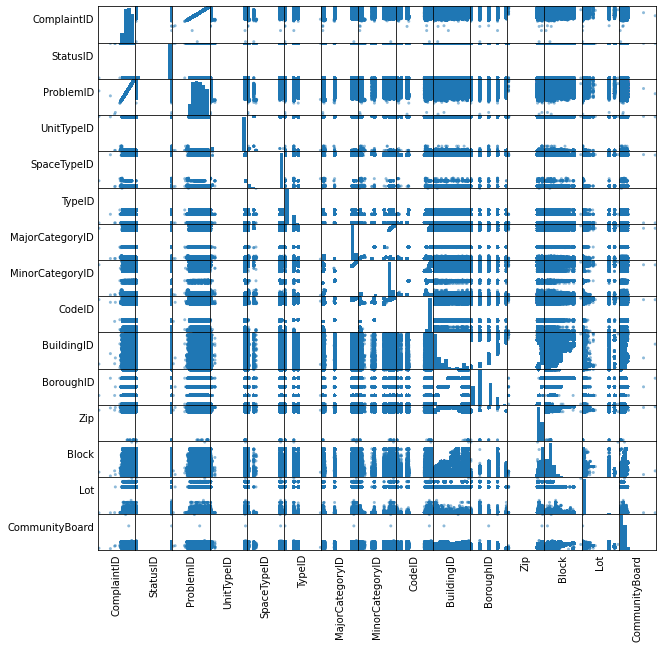

KernelInterrupted: Execution interrupted by the Jupyter kernel.

KernelInterrupted: Execution interrupted by the Jupyter kernel.

In [ ]:
#Merged DF Scatter Matrix
import pandas as pd
import pandas.plotting
numeric_features = [t[0] for t in merged_df.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = merged_df.select(numeric_features).sample(False, 0.8).toPandas()
axs = pd.plotting.scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())
#Reference https://towardsdatascience.com/building-a-linear-regression-with-pyspark-and-mllib-d065c3ba246a

Next in our preliminary data exploration we take a look at some of the potential categorical predictors. 

One predictor in our model is the spaceType - this variable describes the location of the complaint, with the two most common spaceTypes being Entire Apartment and Building-Wide. There are 50 different spaceTypes in our data. 

In [5]:
from pyspark.sql.functions import sum,avg,max,min,mean,count, desc

tot = merged_df.count()

space_df = merged_df.groupby('spaceType') \
    .agg(count('ComplaintID').alias("Count"), \
        ((count('ComplaintID') / tot)*100).alias('Percentage'), \
        avg('closeTime').alias('Avg closeTime')
    )

In [6]:
space_df.count()

50

In [ ]:
space_df.sort(desc("Count")).show(25)

+--------------------+-------+--------------------+------------------+
|           spaceType|  Count|          Percentage|     Avg closeTime|
+--------------------+-------+--------------------+------------------+
|    ENTIRE APARTMENT|1355020|   32.92150874982476|11.559601603034842|
|       BUILDING-WIDE| 778869|  18.923368362435436|4.1403645769784525|
|            BATHROOM| 599742|  14.571306328052284| 17.40558891354842|
|             KITCHEN| 429393|  10.432514211313121|18.849650064630325|
|             BEDROOM| 285107|   6.926947642939801| 17.54490673513339|
|         LIVING ROOM| 164918|   4.006840769880593|18.174292176802684|
|      ENTRANCE/FOYER| 117295|   2.849794371161087| 18.77330934761109|
|     OTHER ROOM/AREA|  86103|  2.0919548551948766| 18.80547973844063|
|   BUILDING ENTRANCE|  66031|  1.6042863900604265|22.596274420717855|
|             HALLWAY|  50507|  1.2271159410395414| 21.56165604086643|
|        PRIVATE HALL|  42007|  1.0206002996663437|17.518151736615327|
|     

We then look at the major category variable, which describes the complaint type. In our data there are 16 different major categories for complaints, with heat/hot water comprising 34% of all complaints and taking an average of only 3 days to be resolved. 

In [ ]:
maj_cat_df = merged_df.groupby('MajorCategory') \
    .agg(count('ComplaintID').alias("Count"), \
        ((count('ComplaintID') / tot)*100).alias('Percentage'), \
        avg('closeTime').alias('Avg closeTime')
    )

In [ ]:
maj_cat_df.count()

16

In [ ]:
maj_cat_df.sort(desc("Count")).show(25)

+--------------------+-------+--------------------+------------------+
|       MajorCategory|  Count|          Percentage|     Avg closeTime|
+--------------------+-------+--------------------+------------------+
|      HEAT/HOT WATER|1395416|   33.90296826146144| 3.056001467687933|
|UNSANITARY CONDITION| 586771|  14.256163459316785| 20.95189683999189|
|       PAINT/PLASTER| 438953|  10.664783567963447|17.467173189957624|
|            PLUMBING| 382913|   9.303238092368858|17.616458820303215|
|         DOOR/WINDOW| 285059|   6.925781436964988| 17.81920652238738|
|          WATER LEAK| 234334|  5.6933689771231695|18.980633404603086|
|            ELECTRIC| 191411|   4.650513580104137|17.245894701644207|
|     FLOORING/STAIRS| 185975|   4.518440753456525|17.990046888778956|
|             GENERAL| 184198|   4.475266836430623| 21.50981991387185|
|           APPLIANCE| 103470|  2.5139027544570327|20.748093447645928|
|              SAFETY| 102867|    2.49925229189844| 17.54508336168765|
|    O

In [ ]:
counts_Type = merged_df.groupby('Type').count()
counts_Type.show()


+-------------------+-------+
|               Type|  count|
+-------------------+-------+
|          HAZARDOUS|     28|
|      NON EMERGENCY|1404254|
|IMMEDIATE EMERGENCY| 146379|
|          EMERGENCY|2565250|
+-------------------+-------+



In [ ]:
import pyspark.sql.functions as f
counts_Type = counts_Type.withColumn('count_percent', f.col('count')/merged_df.count())
counts_Type.show()


+-------------------+-------+--------------------+
|               Type|  count|       count_percent|
+-------------------+-------+--------------------+
|          HAZARDOUS|     28|6.802868186411222E-6|
|      NON EMERGENCY|1404254| 0.34117695936573944|
|IMMEDIATE EMERGENCY| 146379| 0.03556418008066744|
|          EMERGENCY|2565250|  0.6232520576854067|
+-------------------+-------+--------------------+



In [ ]:
# Get counts of complaints per zipcode 

count_Zip = merged_df.groupby('Zip').count()
count_Zip.show()

# zipcode 11452 and 2018 are not real zipcodes...how did they get in our dataset?

+-----+------+
|  Zip| count|
+-----+------+
|11236| 24624|
|11205| 13129|
|10309|  1000|
|11106| 10612|
|11218| 29467|
|10452|107727|
|11428|  2579|
| 2016|    38|
|11237| 38862|
|11379|  2579|
|11364|  2446|
|11109|    52|
|11249|  9795|
|10012|  9404|
|11001|   175|
|11238| 34206|
|10039| 25879|
|11385| 32748|
|11427|  3644|
|11367|  7816|
+-----+------+
only showing top 20 rows



In [ ]:
import pyspark.sql.functions as f
count_Zip = count_Zip.withColumn('count_percent', f.col('count')/merged_df.count())
count_Zip.show()

+-----+------+--------------------+
|  Zip| count|       count_percent|
+-----+------+--------------------+
|11236| 24624|0.005982636650792...|
|11205| 13129|0.003189816300692...|
|10309|  1000|2.429595780861150...|
|11106| 10612|0.002578287042649853|
|11218| 29467|0.007159289887463553|
|10452|107727| 0.02617330646848292|
|11428|  2579|6.265927518840908E-4|
| 2016|    38|9.232463967272373E-6|
|11237| 38862|0.009441895123582605|
|11379|  2579|6.265927518840908E-4|
|11364|  2446|5.942791279986375E-4|
|11109|    52|1.263389806047798...|
|11249|  9795|0.002379789067353497|
|10012|  9404|0.002284791872321...|
|11001|   175|4.251792616507014E-5|
|11238| 34206|0.008310675328013653|
|10039| 25879|0.006287550921290572|
|11385| 32748|0.007956440263164097|
|11427|  3644|8.853447025458034E-4|
|11367|  7816|0.001898972062321...|
+-----+------+--------------------+
only showing top 20 rows



In [ ]:
# MinorCategory

counts_MinorCategory = merged_df.groupby('MinorCategory').count()
counts_MinorCategory.show()


+---------------+------+
|  MinorCategory| count|
+---------------+------+
|   SHOWER-STALL|    20|
|      SPRINKLER|  1757|
|  GUTTER/LEADER|   983|
|  JANITOR/SUPER|  9083|
|      DAMP SPOT| 30848|
|       RADIATOR| 48413|
|         SEWAGE| 14450|
|ENTIRE BUILDING|905689|
| SMOKE DETECTOR| 32250|
|    NO LIGHTING| 45551|
|   HEAT RELATED|  3591|
|       PAVEMENT|  2142|
|     DOOR/FRAME|  4457|
|      SLOW LEAK| 98054|
|         TOILET| 53822|
|        ROOFING|  4064|
|           MOLD|181646|
|        FENCING|     1|
|    WATER-LEAKS|   225|
|     HEAT-PLANT|     9|
+---------------+------+
only showing top 20 rows



In [ ]:
import pyspark.sql.functions as f
counts_MinorCategory = counts_MinorCategory.withColumn('count_percent', f.col('count')/merged_df.count())
counts_MinorCategory.show()

+---------------+------+--------------------+
|  MinorCategory| count|       count_percent|
+---------------+------+--------------------+
|   SHOWER-STALL|    20|4.859191561722302E-6|
|      SPRINKLER|  1757|4.268799786973042E-4|
|  GUTTER/LEADER|   983|2.388292652586511...|
|  JANITOR/SUPER|  9083|0.002206801847756...|
|      DAMP SPOT| 30848|0.007494817064800478|
|       RADIATOR| 48413|0.011762402053883089|
|         SEWAGE| 14450|0.003510765903344...|
|ENTIRE BUILDING|905689|  0.2200458173172355|
| SMOKE DETECTOR| 32250| 0.00783544639327721|
|    NO LIGHTING| 45551|0.011067051741400628|
|   HEAT RELATED|  3591|8.724678449072393E-4|
|       PAVEMENT|  2142|5.204194162604585E-4|
|     DOOR/FRAME|  4457|0.001082870839529815|
|      SLOW LEAK| 98054| 0.02382315846965593|
|         TOILET| 53822|0.013076570411750886|
|        ROOFING|  4064|9.873877253419718E-4|
|           MOLD|181646| 0.04413263552103046|
|        FENCING|     1|2.429595780861151E-7|
|    WATER-LEAKS|   225|5.46659050

In [ ]:
#SpaceType 

counts_SpaceType = merged_df.groupby('SpaceType').count()
counts_SpaceType.show()


+--------------------+-------+
|           SpaceType|  count|
+--------------------+-------+
|    ENTIRE APARTMENT|1355020|
|PUBLIC HALL BULKHEAD|      2|
|             TERRACE|      2|
|           BEDROOM 3|     31|
|   FIRE STAIRS/TOWER|    920|
|     ENTIRE BUILDING|   6214|
|               STOOP|   1230|
|         KITCHENETTE|      5|
|            ENTRANCE|     61|
|         LIVING ROOM| 164918|
|FIRE EXIT/PASSAGEWAY|   2301|
|           BEDROOM 2|     80|
|             BEDROOM| 285107|
|               FOYER|     18|
|           COURTYARD|   8412|
|            BASEMENT|  17510|
|   BUILDING ENTRANCE|  66031|
|            ELEVATOR|   8646|
|       BUILDING-WIDE| 778869|
|        LAUNDRY ROOM|   2543|
+--------------------+-------+
only showing top 20 rows



In [ ]:
# Calculating percentages for SpaceType

import pyspark.sql.functions as f
counts_SpaceType = counts_SpaceType.withColumn('count_percent', f.col('count')/merged_df.count())
counts_SpaceType.show()

+--------------------+-------+--------------------+
|           SpaceType|  count|       count_percent|
+--------------------+-------+--------------------+
|    ENTIRE APARTMENT|1355020|  0.3292150874982476|
|PUBLIC HALL BULKHEAD|      2|4.859191561722302E-7|
|             TERRACE|      2|4.859191561722302E-7|
|           BEDROOM 3|     31|7.531746920669567E-6|
|   FIRE STAIRS/TOWER|    920|2.235228118392258...|
|     ENTIRE BUILDING|   6214|0.001509750818227...|
|               STOOP|   1230|2.988402810459215...|
|         KITCHENETTE|      5|1.214797890430575...|
|            ENTRANCE|     61|1.482053426325302E-5|
|         LIVING ROOM| 164918| 0.04006840769880592|
|FIRE EXIT/PASSAGEWAY|   2301|5.590499891761508E-4|
|           BEDROOM 2|     80|1.943676624688920...|
|             BEDROOM| 285107| 0.06926947642939801|
|               FOYER|     18|4.373272405550071...|
|           COURTYARD|   8412|  0.0020437759708604|
|            BASEMENT|  17510|0.004254222212287875|
|   BUILDING

In [ ]:
# Code

counts_Code = merged_df.groupby('Code').count()
counts_Code.show()

+--------------------+-----+
|                Code|count|
+--------------------+-----+
|    ENTIRE APARTMENT|16310|
|NO LIGHTS ON ONE ...|    6|
|PEELING OR FLAKIN...|19133|
|FREEZER MAKING LO...|    1|
|              NO GAS|  270|
|            BED BUGS|45954|
| MISSING COVER PLATE|  138|
|CASCADING FROM CE...|   41|
|          LARGE HOLE|    6|
|BUILDING ENTRANCE...|    1|
|   BROKEN OR CRACKED| 2141|
|APARTMENT CREATED...|    1|
| FLEX HOSE IS BROKEN|    1|
| DIRTY OR UNSANITARY|52651|
|            NO WATER|50161|
|            SHUT-OFF|48460|
| DEFECTIVE / MISSING|   26|
|SHUT OFF VALVE BR...| 2388|
|LEAKING TO FLOOR ...|    1|
|COLLAPSING OR FAL...|64558|
+--------------------+-----+
only showing top 20 rows



In [ ]:
# Calculating percentages for Code

import pyspark.sql.functions as f
counts_Code = counts_Code.withColumn('count_percent', f.col('count')/merged_df.count())
counts_Code.show()

+--------------------+-----+--------------------+
|                Code|count|       count_percent|
+--------------------+-----+--------------------+
|    ENTIRE APARTMENT|16310|0.003962670718584537|
|NO LIGHTS ON ONE ...|    6|1.457757468516690...|
|PEELING OR FLAKIN...|19133| 0.00464854560752164|
|FREEZER MAKING LO...|    1|2.429595780861151E-7|
|              NO GAS|  270|6.559908608325108E-5|
|            BED BUGS|45954|0.011164964451369332|
| MISSING COVER PLATE|  138|3.352842177588388E-5|
|CASCADING FROM CE...|   41|9.961342701530717E-6|
|          LARGE HOLE|    6|1.457757468516690...|
|BUILDING ENTRANCE...|    1|2.429595780861151E-7|
|   BROKEN OR CRACKED| 2141|5.201764566823724E-4|
|APARTMENT CREATED...|    1|2.429595780861151E-7|
| FLEX HOSE IS BROKEN|    1|2.429595780861151E-7|
| DIRTY OR UNSANITARY|52651|0.012792064745812045|
|            NO WATER|50161|0.012187095396377618|
|            SHUT-OFF|48460|0.011773821154053137|
| DEFECTIVE / MISSING|   26|6.316949030238992E-6|


Blurp on correlation and how we selected the top 10 predictors

In [ ]:
# Statistical summary of predictor variable(s)
predictor_variables = count_Zip.select(["count"])
predictor_variables.describe().toPandas().transpose

<bound method DataFrame.transpose of   summary               count
0   count                 203
1    mean  20275.423645320196
2  stddev  27475.458709093135
3     min                   1
4     max              148447>

While this shows some information, it might be more informative to look at the Zipcodes with the most complaints and the Zipcodes with the least complaints.

A heat map (Complaints Heat Map), using zip code ("Zip") and complaint id ("ComplaintID") counts, was created visually compare where the density of complaints are greatest.  The shapes of the outlined areas are automatically generated based on zip code and the heat map density color was selected such that hot spots easily stand out.  This creates an easily decipherable picture of complaint concentrations, based on the darker regions.

The second visualization (Complaints Bar Graph) was created from the same dataset using multiple variables.  The bar graph visualization provides additional information regarding the type of issue in addition to the count of complaints by zip code.  The integration of the zip code and complaint id variables, with the addition of a third “Major Category” variable, into one graphic allows us to focus on trends and may assist us in creating clearer projections of building lifecycles.

The three visualization strategies below appeared to be the most appropriate for the dataset to investigate "What is the lapse in time from complaint to resolved?" the question.  Each visualization organized and compared the data in a manner that gave more insight into the location of the complaint concentrations, the reason for the complaints, and categorical causes of the complaint.  Although the bubble visualizations did not show a steady growth in complaints as the age of the buildings progressed it did reveal that the number of complaints did not decrease over time either, indicating that the landlords are not being held accountable for repairs of the deficiencies.  

In [7]:
#approx_percentile(merged_df['closeTime'], .5)

#from pyspark.sql import Window
#import pyspark.sql.functions as F

#grp_window = Window.partitionBy('closeTime')
#magic_percentile = F.expr('percentile_approx(val, 0.5)')

#df.withColumn('med_val', magic_percentile.over(grp_window))



In [ ]:
# Our first attempt at OneHotEncoding



#df = merged_df

# for each level, count freq. val=0 for most freq, then 1, ...
#stringIndexer = StringIndexer(inputCol="MajorCategory", outputCol="MajorCategoryIndex")
#model = stringIndexer.fit(df)
#indexed = model.transform(df)
#indexed.show()

#encoder = OneHotEncoder(inputCol="MajorCategoryIndex", outputCol="MajorCategoryVec")
#model = encoder.fit(indexed)
#encoded = model.transform(indexed)
#encoded.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bb533ae5-e690-403a-aa33-39656e712e82' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>